In [31]:
!pip install --upgrade kagglehub

In [5]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
mohammedabdeldayem_the_fake_or_real_dataset_path = kagglehub.dataset_download('mohammedabdeldayem/the-fake-or-real-dataset')


print('Data source import complete.')


Data source import complete.


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Deep Learning

In [7]:
import os
import librosa
import numpy as np
import hashlib
import matplotlib.pyplot as plt
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, LSTM, Input
from tensorflow.keras.applications import VGG16
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import pandas as pd
import joblib

# Preprocessing functions (reusing your existing code)
def compute_md5(file_path):
    with open(file_path, 'rb') as f:
        return hashlib.md5(f.read()).hexdigest()

def load_and_pad(file_path, sr=16000):
    try:
        y, _ = librosa.load(file_path, sr=sr)
        if len(y) < sr:
            y = np.pad(y, (0, sr - len(y)))
        return y
    except:
        return None

def preprocess_audio_dir(base_path):
    all_audio = []
    all_labels = []
    seen_hashes = set()
    for label_name in ['real', 'fake']:
        label_dir = os.path.join(base_path, label_name)
        label = 0 if label_name == 'real' else 1
        for file in tqdm(os.listdir(label_dir), desc=f"Processing {label_name}"):
            path = os.path.join(label_dir, file)
            if os.path.getsize(path) == 0:
                continue
            file_hash = compute_md5(path)
            if file_hash in seen_hashes:
                continue
            seen_hashes.add(file_hash)
            y = load_and_pad(path)
            if y is None:
                continue
            all_audio.append(y)
            all_labels.append(label)
    return all_audio, all_labels

# Enhanced feature extraction for deep learning (generating spectrograms)
def extract_mfcc_spectrograms(audio_list, sr=16000, n_mfcc=40):
    """Extract MFCC spectrograms for deep learning models"""
    spectrograms = []
    for y in tqdm(audio_list, desc="Extracting MFCC Spectrograms"):
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
        # Normalize mfcc features per audio file
        mfcc = (mfcc - np.mean(mfcc)) / (np.std(mfcc) + 1e-8)
        # Pad or trim to fixed size (e.g., 40 x 64)
        if mfcc.shape[1] < 64:
            pad_width = 64 - mfcc.shape[1]
            mfcc = np.pad(mfcc, ((0, 0), (0, pad_width)))
        else:
            mfcc = mfcc[:, :64]
        spectrograms.append(mfcc)

    # Convert to numpy array and reshape for CNN (add channel dimension)
    spectrograms = np.array(spectrograms)
    spectrograms = np.expand_dims(spectrograms, axis=-1)  # Shape: (n_samples, n_mfcc, time_steps, 1)
    return spectrograms

# Create VGG16-based model for deepfake detection
def create_vgg16_model(input_shape):
    """Create a VGG16-based transfer learning model"""
    # Create a base model from VGG16 without the top layer
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(64, 64, 3))

    # Freeze the base model layers
    for layer in base_model.layers:
        layer.trainable = False

    # Create new model
    inputs = Input(shape=input_shape)

    # Convert grayscale to 3-channel (if input is grayscale)
    if input_shape[-1] == 1:
        x = tf.keras.layers.Conv2D(3, (1, 1), padding='same')(inputs)
    else:
        x = inputs

    # Resize to 64x64 if needed
    x = tf.keras.layers.Resizing(64, 64)(x)

    # Pass through the VGG16 model
    x = base_model(x)

    # Add classification layers
    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.3)(x)
    outputs = Dense(2, activation='softmax')(x)

    # Create the model
    model = Model(inputs=inputs, outputs=outputs)

    # Compile the model
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# Create LSTM model for deepfake detection
def create_lstm_model(input_shape):
    """Create an LSTM model for MFCC sequence analysis"""
    # Reshape input to be suitable for LSTM (samples, time steps, features)
    lstm_input_shape = (input_shape[1], input_shape[0])  # (time_steps, features)

    model = Sequential([
        Input(shape=input_shape),
        tf.keras.layers.Reshape(lstm_input_shape),
        LSTM(128, return_sequences=True),
        Dropout(0.2),
        LSTM(64),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(2, activation='softmax')
    ])

    # Compile the model
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# Data preparation for VGG16
def prepare_data_for_dl(X_spectrograms, y_labels):
    """Prepare data for deep learning models"""
    # Convert labels to categorical
    y_categorical = to_categorical(y_labels, num_classes=2)

    return X_spectrograms, y_categorical

# Main execution
if __name__ == "__main__":
    # Dataset paths (reusing your paths)
    dataset_dirs = {
      #  "2seconds": "/kaggle/input/the-fake-or-real-dataset/for-2sec/for-2seconds",
         "norm": r"C:\Users\IIT - MANDI\Downloads\archive (5)\for-norm\for-norm",
       #  "original": "/kaggle/input/the-fake-or-real-dataset/for-original/for-original",
        # "rerec": "/kaggle/input/the-fake-or-real-dataset/for-rerec/for-rerecorded"
    }

    all_results = {}

    for name, dataset_dir in dataset_dirs.items():
        print(f"Processing dataset: {name}")

        # Load data from directories
        train_path = os.path.join(dataset_dir, 'training')
        val_path = os.path.join(dataset_dir, 'validation')
        test_path = os.path.join(dataset_dir, 'testing')

        X_train_raw, y_train = preprocess_audio_dir(train_path)
        X_val_raw, y_val = preprocess_audio_dir(val_path)
        X_test_raw, y_test = preprocess_audio_dir(test_path)

        # Extract MFCC spectrograms for deep learning
        X_train_spectrograms = extract_mfcc_spectrograms(X_train_raw)
        X_val_spectrograms = extract_mfcc_spectrograms(X_val_raw)
        X_test_spectrograms = extract_mfcc_spectrograms(X_test_raw)

        # Prepare data for deep learning
        X_train_dl, y_train_dl = prepare_data_for_dl(X_train_spectrograms, y_train)
        X_val_dl, y_val_dl = prepare_data_for_dl(X_val_spectrograms, y_val)
        X_test_dl, y_test_dl = prepare_data_for_dl(X_test_spectrograms, y_test)

Processing dataset: norm


Processing real:   0%|          | 0/26941 [00:00<?, ?it/s]C:\Users\IIT - MANDI\anaconda3\Lib\site-packages\paramiko\pkey.py:82: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "cipher": algorithms.TripleDES,
C:\Users\IIT - MANDI\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.Blowfish and will be removed from this module in 45.0.0.
  "class": algorithms.Blowfish,
C:\Users\IIT - MANDI\anaconda3\Lib\site-packages\paramiko\transport.py:243: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "class": algorithms.TripleDES,
Extracting MFCC Spectrograms: 100%|██████████| 4634/4634 [00:29<00:00, 154.47it/s]


In [9]:
        # Set up callbacks
        checkpoint_vgg = ModelCheckpoint(
            f"{name}_vgg16_model.keras",  # Using the .keras extension
            monitor='val_accuracy',
            save_best_only=True,
            mode='max',
            verbose=1
        )

        checkpoint_lstm = ModelCheckpoint(
            f"{name}_lstm_model.keras",  # Change this extension too
            monitor='val_accuracy',
            save_best_only=True,
            mode='max',
            verbose=1
        )

        early_stopping = EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True
        )

        # Create and train VGG16 model
        print("Training VGG16 model...")
        input_shape = X_train_spectrograms.shape[1:]
        vgg16_model = create_vgg16_model(input_shape)

        vgg16_history = vgg16_model.fit(
            X_train_dl,
            y_train_dl,
            validation_data=(X_val_dl, y_val_dl),
            epochs=20,
            batch_size=32,
            callbacks=[checkpoint_vgg, early_stopping]
        )

        # Create and train LSTM model
        print("Training LSTM model...")
        lstm_model = create_lstm_model(input_shape)

        lstm_history = lstm_model.fit(
            X_train_dl,
            y_train_dl,
            validation_data=(X_val_dl, y_val_dl),
            epochs=20,
            batch_size=32,
            callbacks=[checkpoint_lstm, early_stopping]
        )

        # Evaluate models
        vgg16_eval = vgg16_model.evaluate(X_test_dl, y_test_dl)
        lstm_eval = lstm_model.evaluate(X_test_dl, y_test_dl)

        # Get predictions
        vgg16_pred = np.argmax(vgg16_model.predict(X_test_dl), axis=1)
        lstm_pred = np.argmax(lstm_model.predict(X_test_dl), axis=1)
        y_test_classes = np.argmax(y_test_dl, axis=1)

        # Calculate metrics
        vgg16_accuracy = accuracy_score(y_test_classes, vgg16_pred)
        lstm_accuracy = accuracy_score(y_test_classes, lstm_pred)

        vgg16_report = classification_report(y_test_classes, vgg16_pred, output_dict=True)
        lstm_report = classification_report(y_test_classes, lstm_pred, output_dict=True)

        # Store results
        results = {
            "VGG16": {
                "accuracy": vgg16_accuracy,
                "precision": vgg16_report['weighted avg']['precision'],
                "recall": vgg16_report['weighted avg']['recall'],
                "f1": vgg16_report['weighted avg']['f1-score']
            },
            "LSTM": {
                "accuracy": lstm_accuracy,
                "precision": lstm_report['weighted avg']['precision'],
                "recall": lstm_report['weighted avg']['recall'],
                "f1": lstm_report['weighted avg']['f1-score']
            }
        }

        all_results[name] = results

        # Plot training history
        plt.figure(figsize=(12, 4))

        plt.subplot(1, 2, 1)
        plt.plot(vgg16_history.history['accuracy'], label='Train Accuracy')
        plt.plot(vgg16_history.history['val_accuracy'], label='Validation Accuracy')
        plt.title(f'VGG16 Model Accuracy - {name}')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(lstm_history.history['accuracy'], label='Train Accuracy')
        plt.plot(lstm_history.history['val_accuracy'], label='Validation Accuracy')
        plt.title(f'LSTM Model Accuracy - {name}')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()

        plt.tight_layout()
        plt.savefig(f"{name}_training_history.png")
        plt.close()

        # Plot confusion matrices
        plt.figure(figsize=(12, 5))

        plt.subplot(1, 2, 1)
        vgg16_cm = confusion_matrix(y_test_classes, vgg16_pred)
        plt.imshow(vgg16_cm, cmap='Blues')
        plt.title(f'VGG16 Confusion Matrix - {name}')
        plt.colorbar()
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.xticks([0, 1], ['Real', 'Fake'])
        plt.yticks([0, 1], ['Real', 'Fake'])

        for i in range(2):
            for j in range(2):
                plt.text(j, i, f"{vgg16_cm[i, j]}", ha='center', va='center')

        plt.subplot(1, 2, 2)
        lstm_cm = confusion_matrix(y_test_classes, lstm_pred)
        plt.imshow(lstm_cm, cmap='Blues')
        plt.title(f'LSTM Confusion Matrix - {name}')
        plt.colorbar()
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.xticks([0, 1], ['Real', 'Fake'])
        plt.yticks([0, 1], ['Real', 'Fake'])

        for i in range(2):
            for j in range(2):
                plt.text(j, i, f"{lstm_cm[i, j]}", ha='center', va='center')

        plt.tight_layout()
        plt.savefig(f"{name}_confusion_matrices.png")
        plt.close()

    # Print final results as DataFrame
print("\nFinal results:")
final_df = pd.DataFrame({ds: res for ds, res in all_results.items()}).T
print(final_df)

Training VGG16 model...
Epoch 1/20
1684/1684 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - accuracy: 0.8699 - loss: 0.3154
Epoch 1: val_accuracy improved from -inf to 0.94536, saving model to norm_vgg16_model.keras
1684/1684 ━━━━━━━━━━━━━━━━━━━━ 305s 180ms/step - accuracy: 0.8699 - loss: 0.3153 - val_accuracy: 0.9454 - val_loss: 0.1504
Epoch 2/20
1684/1684 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - accuracy: 0.9357 - loss: 0.1678
Epoch 2: val_accuracy improved from 0.94536 to 0.96083, saving model to norm_vgg16_model.keras
1684/1684 ━━━━━━━━━━━━━━━━━━━━ 297s 177ms/step - accuracy: 0.9357 - loss: 0.1678 - val_accuracy: 0.9608 - val_loss: 0.1094
Epoch 3/20
1684/1684 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy: 0.9473 - loss: 0.1409
Epoch 3: val_accuracy improved from 0.96083 to 0.96092, saving model to norm_vgg16_model.keras
1684/1684 ━━━━━━━━━━━━━━━━━━━━ 302s 179ms/step - accuracy: 0.9473 - loss: 0.1409 - val_accuracy: 0.9609 - val_loss: 0.1095
Epoch 4/20
1684/1684 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step

In [13]:
# Save entire VGG16 model
vgg16_model.save(f"vgg16_full.h5")  # Or .keras for newer Keras format

# Save entire LSTM model
lstm_model.save(f"lstm_full.h5")


In [15]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Prepare test labels
y_true = np.argmax(y_test_dl, axis=1)  # If one-hot encoded


In [17]:
# Get predictions
vgg16_pred_probs = vgg16_model.predict(X_test_dl)
vgg16_preds = np.argmax(vgg16_pred_probs, axis=1)

lstm_pred_probs = lstm_model.predict(X_test_dl)
lstm_preds = np.argmax(lstm_pred_probs, axis=1)


145/145 ━━━━━━━━━━━━━━━━━━━━ 11s 74ms/step
145/145 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step


In [19]:
def print_metrics(name, y_true, y_pred):
    print(f"--- {name} Model Evaluation ---")
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("Precision:", precision_score(y_true, y_pred, average='weighted'))
    print("Recall:", recall_score(y_true, y_pred, average='weighted'))
    print("F1 Score:", f1_score(y_true, y_pred, average='weighted'))
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred))

print_metrics("VGG16", y_true, vgg16_preds)
print_metrics("LSTM", y_true, lstm_preds)


--- VGG16 Model Evaluation ---
Accuracy: 0.860164005179111
Precision: 0.8644874430154827
Recall: 0.860164005179111
F1 Score: 0.8595321703707628

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.80      0.85      2264
           1       0.83      0.92      0.87      2370

    accuracy                           0.86      4634
   macro avg       0.87      0.86      0.86      4634
weighted avg       0.86      0.86      0.86      4634

--- LSTM Model Evaluation ---
Accuracy: 0.9475615019421666
Precision: 0.9476936157344698
Recall: 0.9475615019421666
F1 Score: 0.9475458401253568

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.94      0.95      2264
           1       0.94      0.96      0.95      2370

    accuracy                           0.95      4634
   macro avg       0.95      0.95      0.95      4634
weighted avg       0.95      0.95      0.95      4634



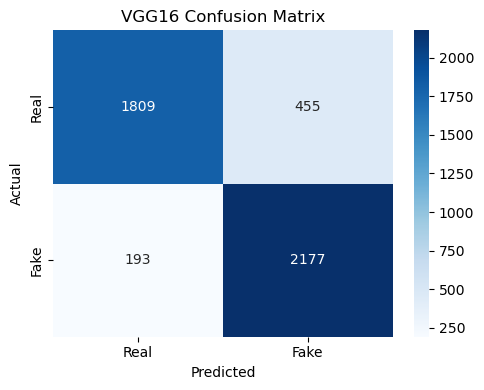

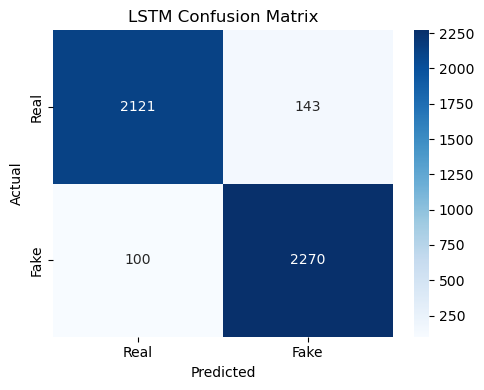

In [21]:
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
    plt.title(f'{title} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()

plot_confusion_matrix(y_true, vgg16_preds, "VGG16")
plot_confusion_matrix(y_true, lstm_preds, "LSTM")


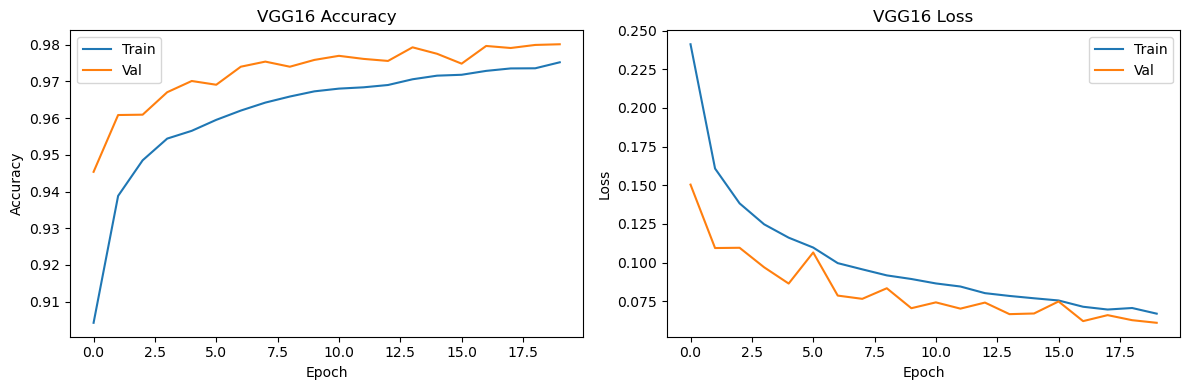

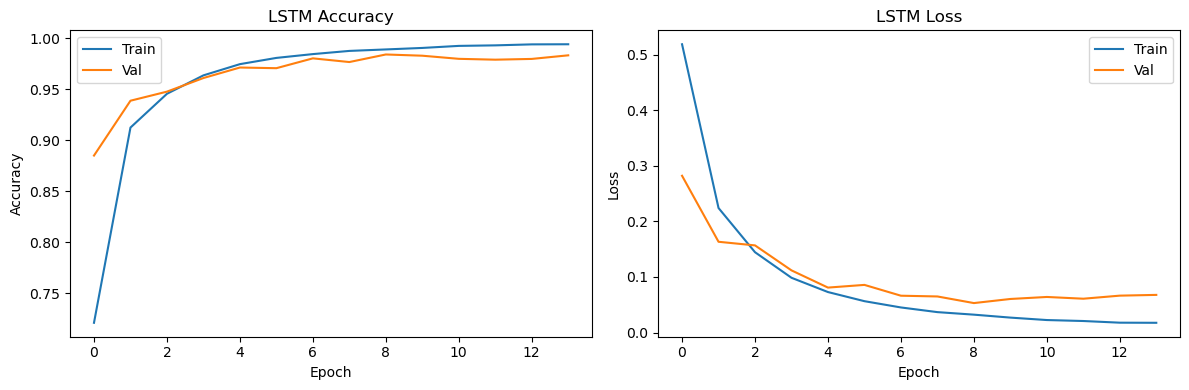

In [23]:
def plot_history(history, model_name):
    plt.figure(figsize=(12, 4))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train')
    plt.plot(history.history['val_accuracy'], label='Val')
    plt.title(f'{model_name} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Val')
    plt.title(f'{model_name} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_history(vgg16_history, "VGG16")
plot_history(lstm_history, "LSTM")


In [31]:
model = vgg16_model  # Replace with lstm_model if needed

train_accuracies = []
train_losses = []
test_accuracies = []
test_losses = []

num_epochs = 20

for epoch in range(num_epochs):
    history = model.fit(
        X_train_dl, y_train_dl,
        epochs=1,
        batch_size=32,
        verbose=0
    )

    train_accuracies.append(history.history['accuracy'][0])
    train_losses.append(history.history['loss'][0])

    test_loss, test_acc = model.evaluate(X_test_dl, y_test_dl, verbose=0)
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)

    print(f"Epoch {epoch+1}/{num_epochs}: Train Acc = {train_accuracies[-1]:.4f}, Test Acc = {test_accuracies[-1]:.4f}")


Epoch 1/20: Train Acc = 0.9743, Test Acc = 0.8705
Epoch 2/20: Train Acc = 0.9754, Test Acc = 0.8671
Epoch 3/20: Train Acc = 0.9757, Test Acc = 0.8699
Epoch 4/20: Train Acc = 0.9764, Test Acc = 0.8742
Epoch 5/20: Train Acc = 0.9765, Test Acc = 0.8675
Epoch 6/20: Train Acc = 0.9775, Test Acc = 0.8751
Epoch 7/20: Train Acc = 0.9774, Test Acc = 0.8783
Epoch 8/20: Train Acc = 0.9772, Test Acc = 0.8789
Epoch 9/20: Train Acc = 0.9788, Test Acc = 0.8811
Epoch 10/20: Train Acc = 0.9788, Test Acc = 0.8878
Epoch 11/20: Train Acc = 0.9778, Test Acc = 0.8630
Epoch 12/20: Train Acc = 0.9784, Test Acc = 0.8817
Epoch 13/20: Train Acc = 0.9792, Test Acc = 0.8759
Epoch 14/20: Train Acc = 0.9787, Test Acc = 0.8828
Epoch 15/20: Train Acc = 0.9788, Test Acc = 0.8744
Epoch 16/20: Train Acc = 0.9796, Test Acc = 0.8792
Epoch 17/20: Train Acc = 0.9801, Test Acc = 0.8841


KeyboardInterrupt: 

In [11]:
# Print final results in a more readable format
print("\nFinal results:")
for dataset_name, models in all_results.items():
    print(f"\nDataset: {dataset_name}")
    for model_name, metrics in models.items():
        print(f"  {model_name} model:")
        for metric_name, value in metrics.items():
            print(f"    {metric_name}: {value:.4f}")


Final results:

Dataset: norm
  VGG16 model:
    accuracy: 0.8602
    precision: 0.8645
    recall: 0.8602
    f1: 0.8595
  LSTM model:
    accuracy: 0.9476
    precision: 0.9477
    recall: 0.9476
    f1: 0.9475
